
# The Chinese Restaurant Process

The Chinese Restaurant Process is a constructive metaphor for the Dirichlet Process.

## One parameter CRP

The one-parameter metaphor $\text{CRP}(\alpha)$ proceeds as follows;

 1. The first customer enters and sits at the first table
 2. The $i^\text{th}$ customer enters and sits at (a) the $k^\text{th}$ occupied table with probability $m_k / (i - 1 + \alpha)$, where $m_k$ is the number of people already sitting at that table, or (b) an unoccupied table with probability $\alpha / (i - 1 + \alpha)$.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, digamma


In [2]:

# Fix the number of customers throughout
num_customers = 20


In [3]:

def crp_oneparam(alpha, num_customers):
    """One-parameter CRP
    
    Args:
        alpha (float): The concentration parameter
        num_customers (int): Number of customers to simulate
    
    Returns:
        (numpy array): Vector of customer counts at tables
    """

    # Number of customers at each table
    customer_counts = np.zeros(num_customers)

    for i in range(1, num_customers + 1):

        if i == 1:
            # First customer sits at the fist table
            customer_counts[0] += 1

        else:
            # ith customer considers each table in proportion to it's popularity
            probs = np.array(list(customer_counts[np.nonzero(customer_counts)]) + [alpha])
            probs /= np.sum(probs)
            customer_counts[np.random.choice(range(len(probs)), p=probs)] += 1
    
    return customer_counts


def exp_tables_oneparam(alpha, n):
    """Expected number of tables for the one-parameter CRP
    
    N.b. args can also be numpy arrays, and broadcasting will be applied
    
    Args:
        alpha (float): Concentration parameter
        n (int): Number of customers
    
    Returns:
        (float): The expected number of tables
    """
    return alpha * (digamma(alpha + n) - digamma(alpha))


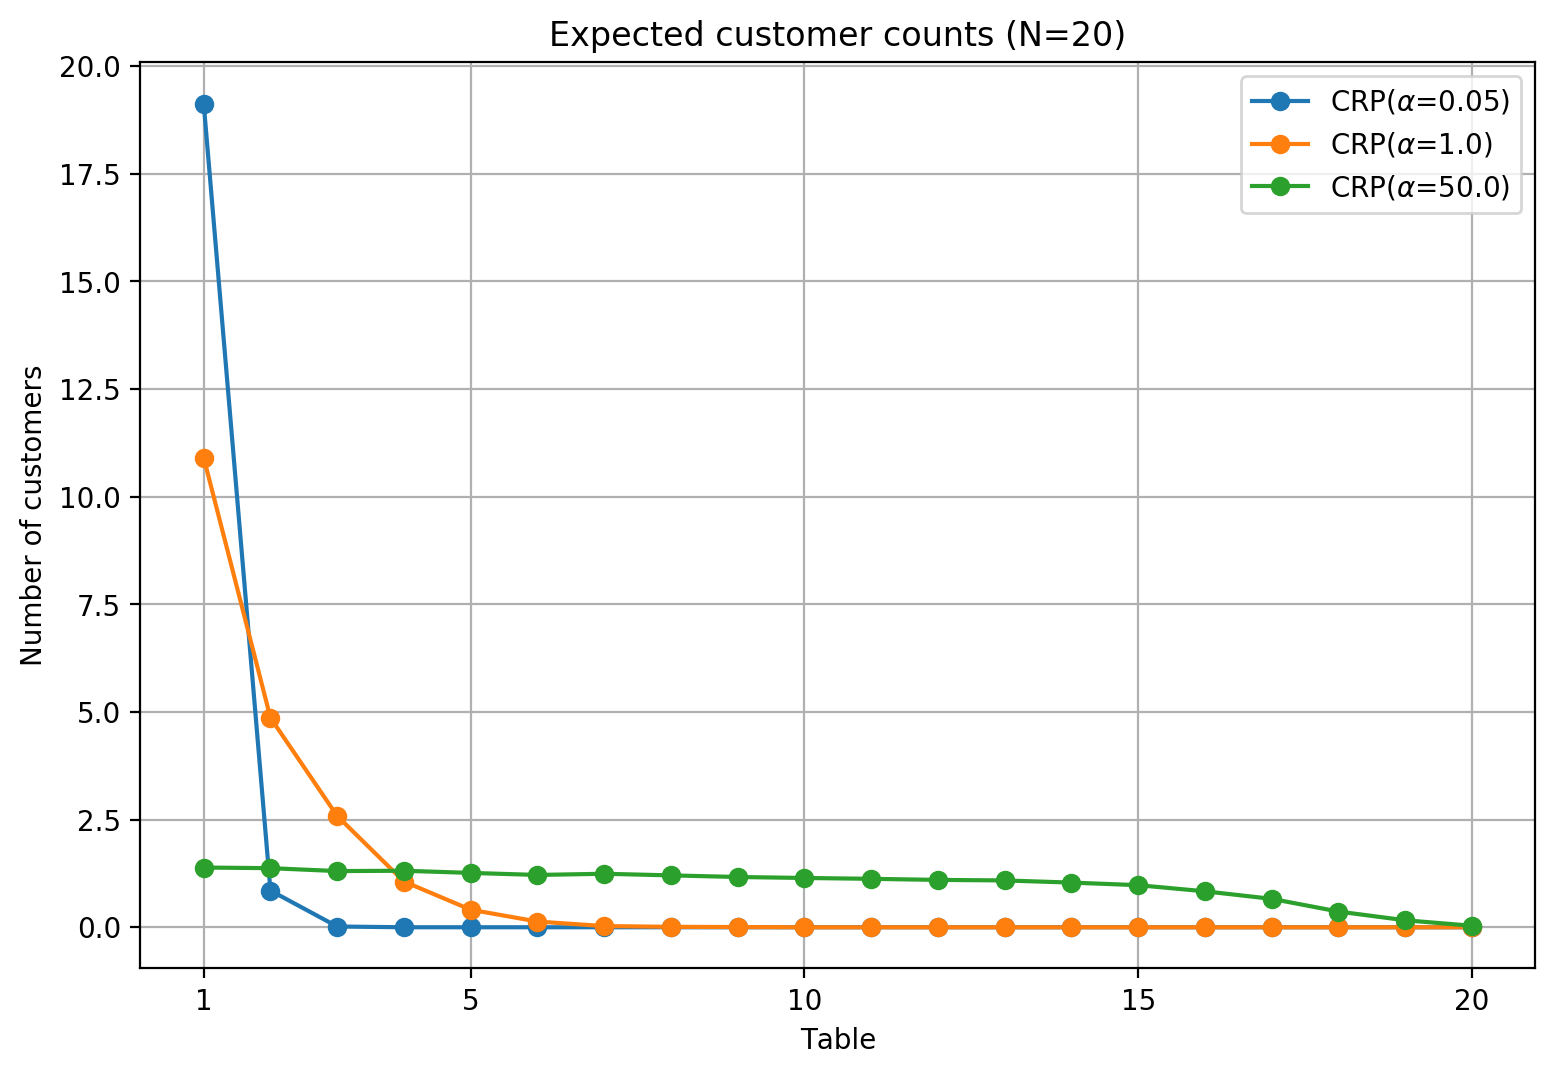

In [4]:

plt.figure(figsize=(9, 6), dpi=200)

num_samples = 400
for alpha in [0.05, 1.0, 50.0]:
    expected_customer_counts = np.zeros(num_customers)
    for _ in range(num_samples):
        expected_customer_counts += crp_oneparam(alpha, num_customers) / num_samples
    
    plt.plot(
        range(1, num_customers + 1),
        expected_customer_counts,
        'o-',
        label=r'CRP($\alpha$=' + str(alpha) + ')'
    )

plt.xticks([1, 5, 10, 15, 20])
plt.grid()
plt.legend()
plt.title("Expected customer counts (N={})".format(num_customers))
plt.xlabel("Table")
plt.ylabel("Number of customers")
plt.show()


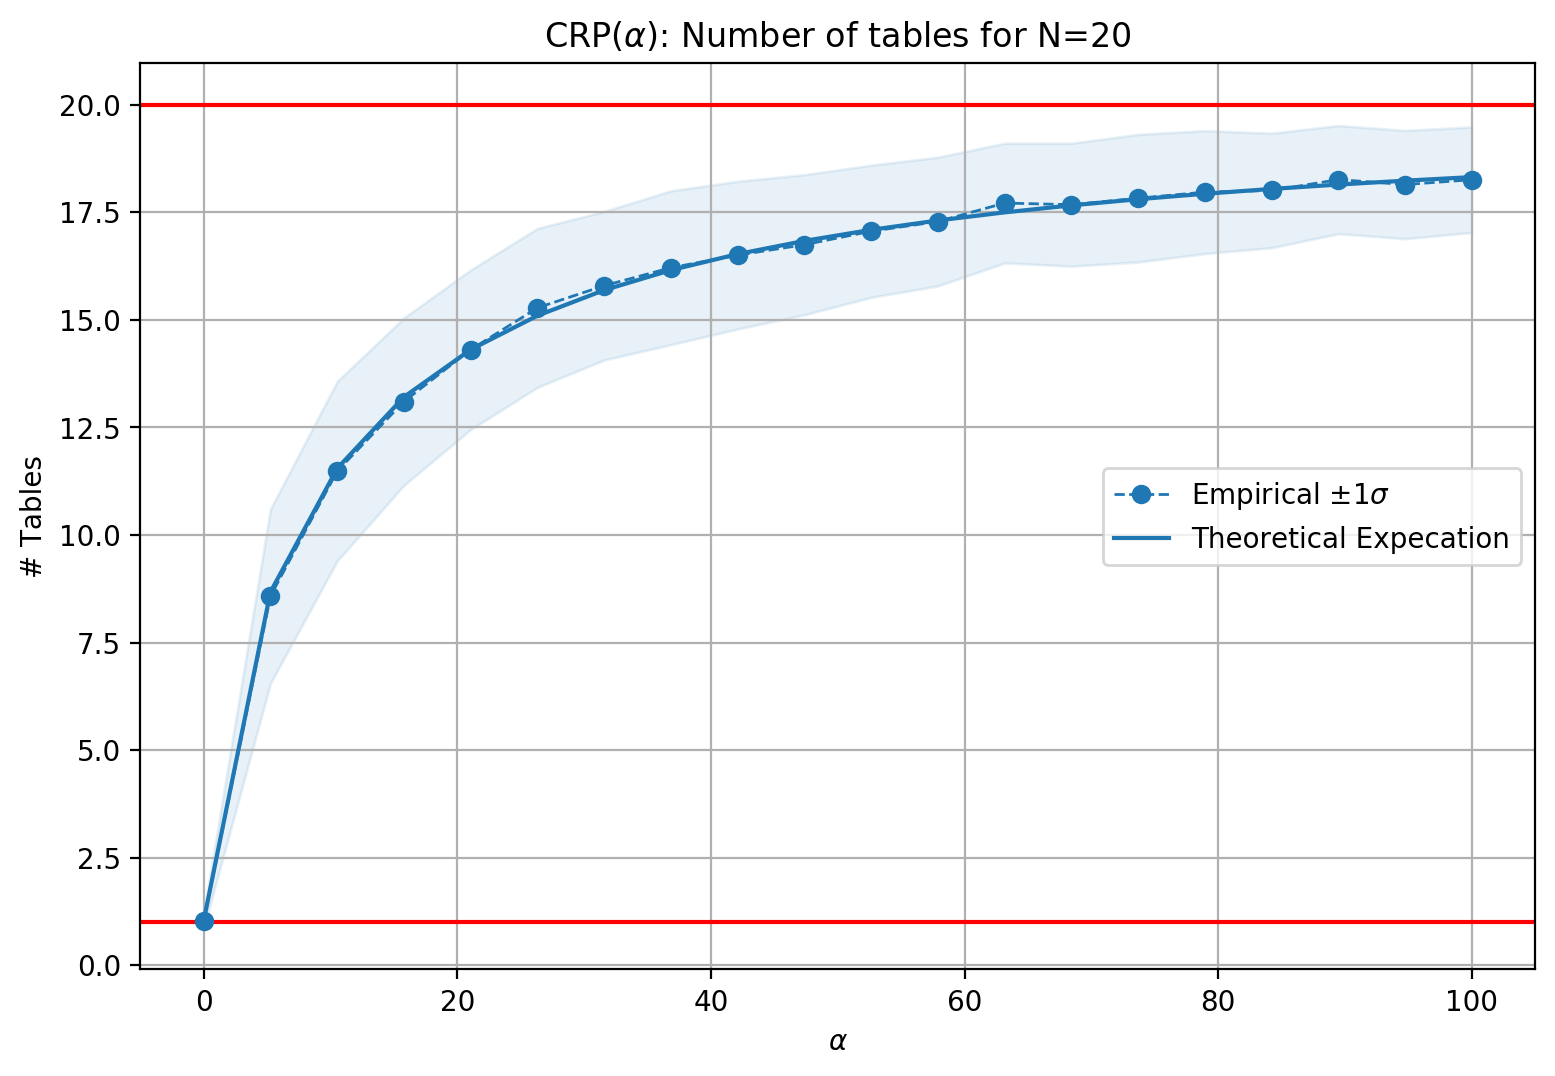

In [5]:

alpha = np.linspace(0.01, 100, 20)
exp_tables_theory = exp_tables_oneparam(alpha, num_customers)

num_samples = 400
exp_tables_sim = []
for a in alpha:
    num_tables = []
    for _ in range(num_samples):
        customer_counts = crp_oneparam(a, num_customers)
        num_tables.append(np.sum(customer_counts != 0))
    exp_tables_sim.append(num_tables)

plt.figure(figsize=(9, 6), dpi=200)

# Plot min and asymptotic max bounds
plt.axhline(1.0, c='r')
plt.axhline(num_customers, c='r')

# Plot simulation results
means, stds = zip(*[(np.mean(s), np.std(s)) for s in exp_tables_sim])
means = np.array(means)
stds = np.array(stds)
p0 = plt.plot(alpha, means, 'o--', lw=1, label=r"Empirical $\pm 1 \sigma$")
plt.fill_between(
    alpha,
    means - stds,
    means + stds,
    color=p0[0].get_color(),
    alpha=0.1
)

# Plot theoretical expectation
plt.plot(alpha, exp_tables_theory, c=p0[0].get_color(), label="Theoretical Expecation")

plt.grid()
plt.title(r"CRP($\alpha$): Number of tables for N={}".format(num_customers))
plt.xlabel(r"$\alpha$")
plt.ylabel("# Tables")
plt.legend()
plt.show()



## Two-parameter CRP

In the two parameter metaphor $\text{CRP}(\alpha, \theta)$, we have parameters $\alpha \in [0, 1)$ and $\theta > -\alpha$.

 1. The first customer enters and sits at the first table
 2. The $i^{th}$ customer enters and sits at (a) the $k^\text{th}$ occupied table with probability $(m_k - \alpha) / (i - 1 + \theta)$, or (b) an unoccupied table with probability $(\theta + K_+ \alpha) / (i - 1 + \theta)$


In [18]:

def crp_twoparam(alpha, theta, num_customers):
    """One-parameter CRP
    
    Args:
        alpha (float): The concentration parameter
        theta (float): The discount parameter
        num_customers (int): Number of customers to simulate
    
    Returns:
        (numpy array): Vector of customer counts at tables
    """
    
    assert 0.0 <= alpha < 1.0, "Alpha ({}) must be in the range [0, 1)".format(alpha)
    assert -alpha < theta, "Theta ({}) must be >= -alpha ({})".format(theta, alpha)

    # Number of customers at each table
    customer_counts = np.zeros(num_customers)

    for i in range(1, num_customers + 1):

        if i == 1:
            # First customer sits at the fist table
            customer_counts[0] += 1

        else:
            # ith customer
            occupied_table_counts = list(customer_counts[np.nonzero(customer_counts)] - alpha)
            num_occupied_tables = len(occupied_table_counts)
            probs = np.array(occupied_table_counts + [theta + num_occupied_tables * alpha])
            probs /= np.sum(probs)
            customer_counts[np.random.choice(range(len(probs)), p=probs)] += 1
    
    return customer_counts

    
def incremental_factorial_power(x, n, a=1.0):
    """From §1.1, p15 in Combinatorial Stochastic Processes by Pittmann, 2006"""
    each = lambda _x: np.product(_x + np.arange(0, n - 1) * a)
    if hasattr(x, '__iter__'):
        return np.array([each(_x) for _x in x])
    return each(x)


def exp_tables_twoparam(alpha, theta, n):
    """Expected number of tables for the two-parameter CRP
    
    N.b. args can also be numpy arrays, and broadcasting will be applied
    
    Args:
        alpha (float): Concentration parameter, must be in the range [0, 1)
        theta (float): Discount parameter, must be in the range (-alpha, \infty)
        n (int): Number of customers
        
    Returns:
        (float): The expected number of tables
    """
    ret = None
    for i in range(1, n + 1):
        v1 = incremental_factorial_power(theta + alpha, i-1)
        v2 = incremental_factorial_power(theta + 1, i-1)
        if ret is None:
            ret = v1 / v2
        else:
            ret += v1 / v2
    return ret


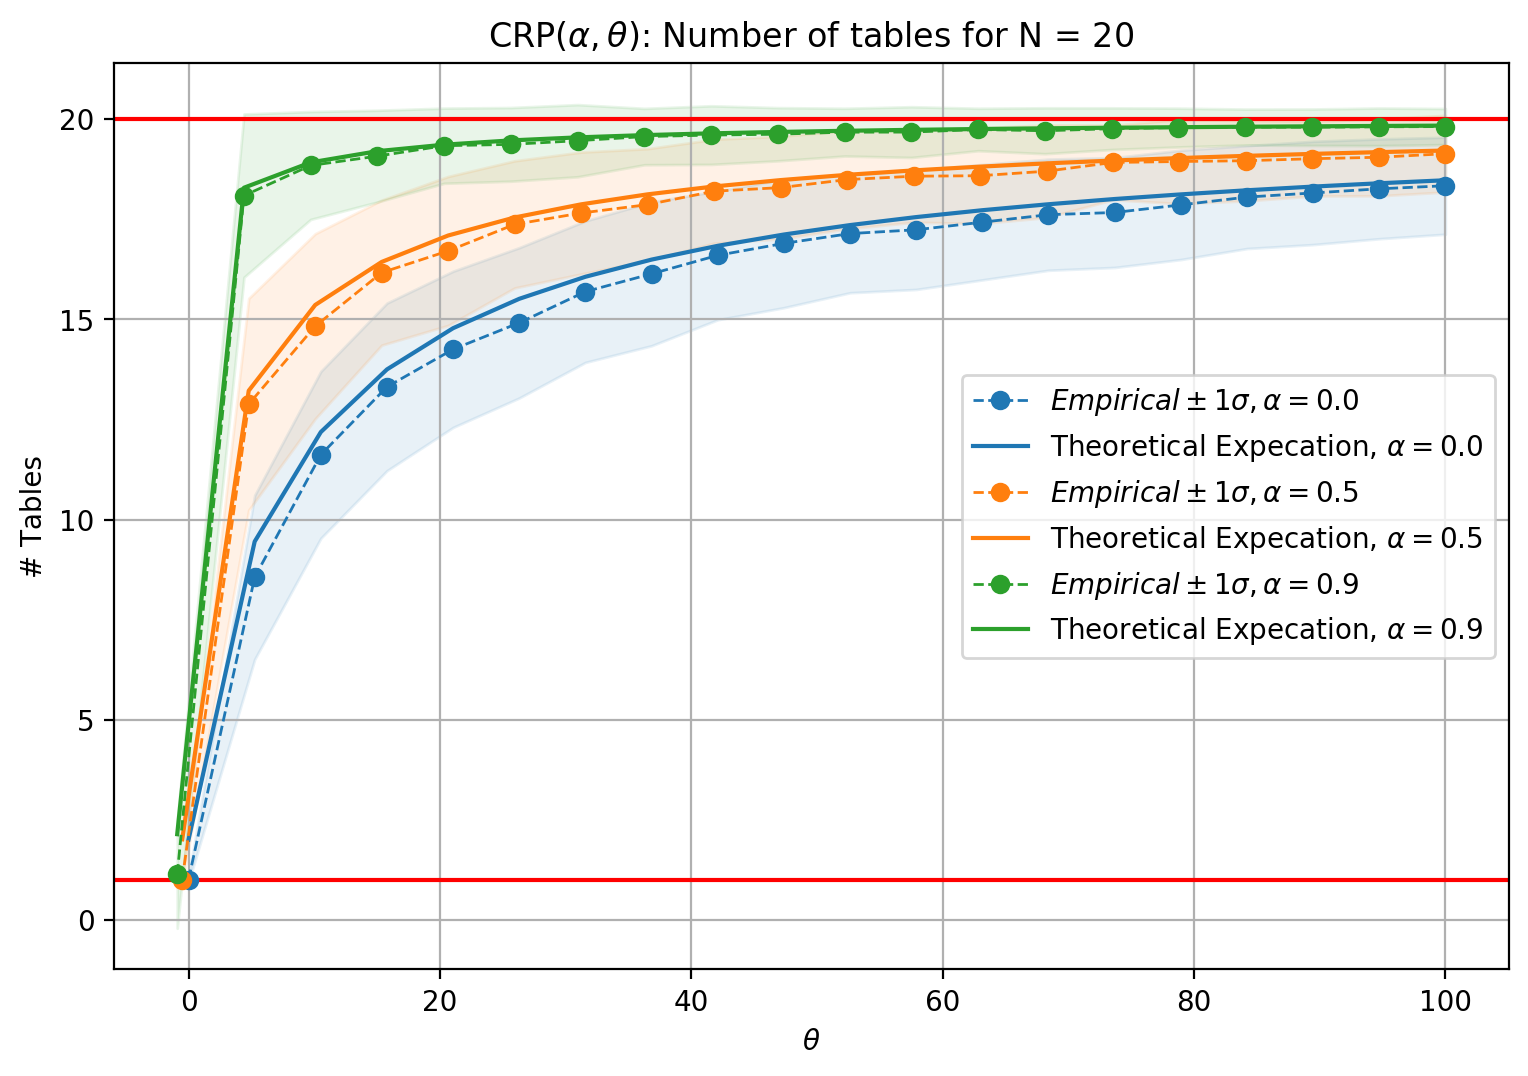

In [17]:

plt.figure(figsize=(9, 6), dpi=200)

# Plot min and asymptotic max bounds
plt.axhline(1.0, c='r')
plt.axhline(num_customers, c='r')

num_samples = 600
for alpha in [0.0, 0.5, 0.9]:
    
    # Plot simulated results
    nt_means = []
    nt_stds = []
    thetas = np.linspace(-alpha + 0.001, 100, 20)
    for theta in thetas:
        num_tables = []
        for _ in range(num_samples):
            nc = crp_twoparam(alpha, theta, num_customers)
            num_tables.append(np.sum(nc > 0))
        nt_means.append(np.mean(num_tables))
        nt_stds.append(np.std(num_tables))
    nt_means = np.array(nt_means)
    nt_stds = np.array(nt_stds)
    
    p0 = plt.plot(thetas, nt_means, 'o--', lw=1, label=r"$Empirical \pm 1 \sigma, \alpha =$" + str(alpha))
    plt.fill_between(
        thetas,
        nt_means - nt_stds,
        nt_means + nt_stds,
        color = p0[0].get_color(),
        alpha=0.1
    )

    # Plot theoretical expectation
    plt.plot(
        thetas,
        exp_tables_twoparam(alpha, thetas, num_customers),
        c=p0[0].get_color(),
        label=r"Theoretical Expecation, $\alpha = $" + str(alpha)
    )

plt.title(r"CRP($\alpha, \theta$): Number of tables for N = {}".format(num_customers))
plt.grid()
plt.xlabel(r"$\theta$")
plt.ylabel("# Tables")
plt.legend()
plt.show()



Foo bar something.
